# 1. Business Problem
## 1.1 Context
Our client is the HR department at a large software company.
* They are rolling out a new initiative that they call "Proactive Retention."
* The idea is to use data to predict whether and employee is likely to leave.
* Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.
* For this initiative, they only care about permanent (non-temp) employees.

## 1.2 Problems with current approach
Currently, their employee retention process is very retroactive. Once an employee leaves, he or she takes an "exit interview" and shares reasons for leaving. HR then tries to learn insights from that interview and make changes around the company accordingly.

This suffers from 3 main problems:
* The first problem with this approach is that it's too haphazard. The quality of insight gained from an interview depends heavily on the skill of the interviewer.
* The second problem is that they can't systematically aggregate insights across all employees who have left.
* The third problem is that they can't be proactive because they are using exit interviews to drive policy changes.

## 1.3 Problem Statement
* The HR department has hired us as data science consultants. They want to supplement their exit interviews with a more proactive approach.
* They've asked their business intelligence analysts to provide us a dataset of past employees and their status (still employed or already left).

## 1.4 Business Objectives and Constraints
* Deliverable: Trained model file
* Model interprtability is very important
* Ouput Probabilities along with the prediction
* No latency constraints

# 2. Machine Learning Problem
## 2.1 Data Overview

For this project:
1. The dataset has 14249 observations for past/present employees.
2. The observations span 12 different departments.
3. Each observation includes the employee’s current employment status.

**Target variable**<br>
'status' – Current employment status (Employed / Left)

**Features**

Administrative information
* 'department' – Department employees belong(ed) to
* 'salary' – Salary level relative to rest of their department
* 'tenure' – Number of years at the company
* 'recently_promoted' – Was the employee promoted in the last 3 years?

Workload information
* 'n_projects' – Number of projects employee is staffed on
* 'avg_monthly_hrs' – Average number of hours worked per month

Mutual evaluation information
* 'satisfaction' – Score for employee’s satisfaction with the company (higher is better)
* 'last_evaluation' – Score for most recent evaluation of employee (higher is better)
* 'filed_complaint' – Has the employee filed a formal complaint in the last 3 years?

## 2.2 Mapping Business problem to ML problem
### 2.2.1 Type of Machine Learning Problem
It is a binary classification task, where given a set of features we need to predict whether the employee is likely to leave or not

### 2.2.2 Evaluation Metric (KPI)
Since this is binary classification problem, we use the following metrics:
* **Confusion matrix** - For getting a better clarity of the no of correct/incorrect predictions by the model
* **ROC-AUC** - It considers the rank of the output probabilities and intuitively measures the likelihood that model can distinguish between a positive point and a negative point. (**Note:** ROC-AUC is typically used for binary classification only). We will use AUC to select the best model.

# 3. Exploratory Data Analysis
Importing the libraries

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# import color maps
from matplotlib.colors import ListedColormap

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function to perform data standardization 
from sklearn.preprocessing import StandardScaler

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBClassifier
from xgboost import plot_importance  ## to plot feature importance

# Evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

# To save the final model on disk
from sklearn.externals import joblib  ## Reference http://scikit-learn.org/stable/modules/model_persistence.html

In [2]:
np.set_printoptions(precision=2, suppress=True)

## 3.1 Reading the data

In [3]:
df = pd.read_csv("Files/employee_data.csv")

In [4]:
# Dataframe dimensions
df.shape

(14249, 10)

In [5]:
# Columns of the dataframe
df.columns

Index(['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation',
       'n_projects', 'recently_promoted', 'salary', 'satisfaction', 'status',
       'tenure'],
      dtype='object')

In [6]:
# First 5 rows
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [7]:
# Column datatypes
df.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object

Make sure all the data types make sense and none seems incorrect

In [8]:
# Last 5 rows
df.tail()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
14244,178,IT,NaN,0.735865,5,NaN,low,0.263282,Employed,5.0
14245,257,sales,NaN,0.638604,3,NaN,low,0.868209,Employed,2.0
14246,232,finance,1.0,0.847623,5,NaN,medium,0.898917,Left,5.0
14247,130,IT,NaN,0.757184,4,NaN,medium,0.641304,Employed,3.0
14248,159,NaN,NaN,0.578742,3,NaN,medium,0.808850,Employed,3.0


## 3.2 Distribution of numeric features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002952282E048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000029522DB8F28>]], dtype=object)

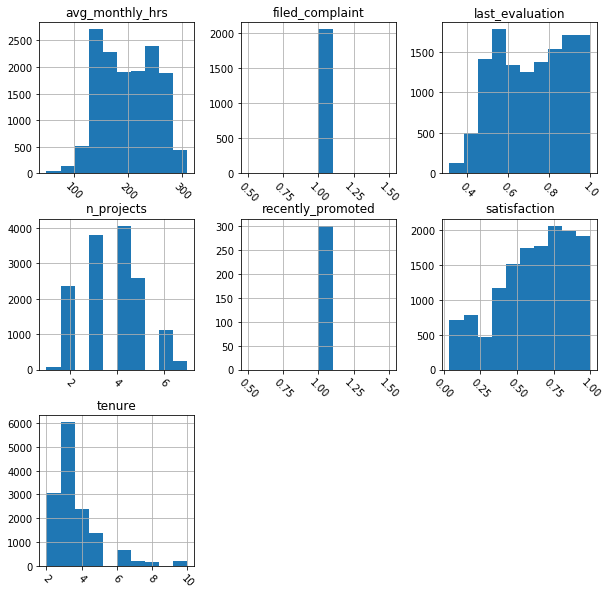

In [9]:
# Plot histogram grid
df.hist(figsize=(10,10), xrot=-45)

**Observations:**
* 'filed_compliant' and 'recently_promoted' must be binary indicator variables.
* 'last_evaluation' ranges approx from 0.4 to 1
* 'satidfaction' ranges approx from 0 to 1
* 'tenure' for most of the employees is less than or equal to 5 years
* 'n_projects' ranges between 2 to 6

Let's plot the kde for avg no of hrs

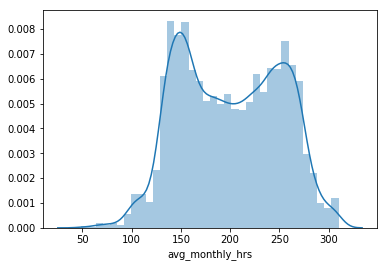

In [10]:
sns.distplot(df['avg_monthly_hrs'])

* Some employees work for around 150 hrs/month i.e. 37.5 hrs/week which is reasonable.
* However there are employees who work for 250 hrs/month i.e. 62.5 hrs/week, which turns out to be 12.5 hrs/day (assuming an employee works 5 days per week). This is a big number

In [11]:
# Summarize numerical features
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


* Just scan over the min, max and mean rows and make sure the values make sense.
* Since std dev of 'filed_complaint' and 'recently promoted' is 0, they must be indicator variables.

## 3.3 Distribution of categorical features

In [12]:
# Summarize categorical features
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


Let's check the frequency of each class of these variables

In [13]:
df['department'].value_counts()

sales                     3923
engineering               2592
support                   2122
IT                        1161
product                    860
marketing                  819
finance                    728
management                 595
information_technology     209
temp                       181
admin                      176
procurement                174
Name: department, dtype: int64

* 'IT' and 'information_technology' must be same departments.
* We must delete the employees belonging to 'temp' department as these are the employees which do not belong to any of the departments. After all, based on the project scope, we're only trying to build a model for permanent, full time employees.

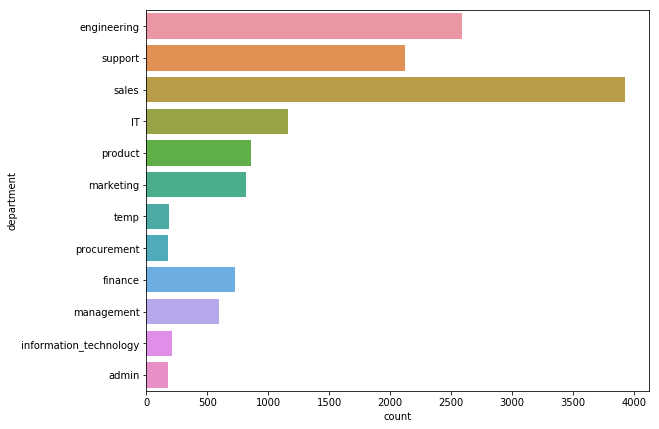

In [14]:
## We can also use bar plots instead
plt.figure(figsize=(9,7))
sns.countplot(y='department', data=df)

In [15]:
df['salary'].value_counts()

low       6952
medium    6146
high      1151
Name: salary, dtype: int64

In [16]:
df['status'].value_counts()

Employed    10857
Left         3392
Name: status, dtype: int64

Approx 23.8% of employees have left and 76.2 are still employeed.

This means the dataset is **not balanced**

## 3.4 Segmentations
Segment the target variable (status) with key features - Univariate segmentations

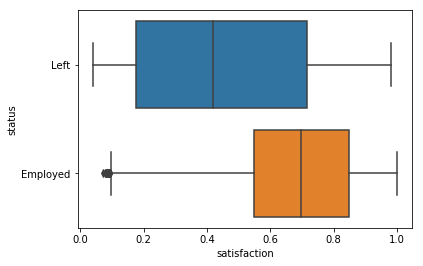

In [17]:
## status vs satisfaction
sns.boxplot(y='status', x='satisfaction', data=df)

This makes intuitive sense as current employees seem to be more satisfied than those who left

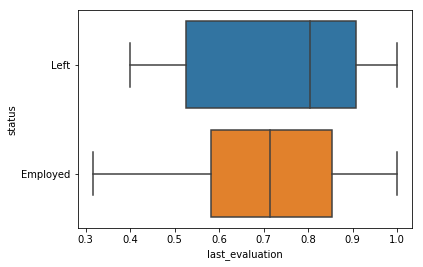

In [18]:
## status vs last_evaluation
sns.boxplot(y='status', x='last_evaluation', data=df)

In [19]:
# Segment by status and display the means within each class
df.groupby('status').mean()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
status,,,,,,,
Employed,197.700286,1.0,0.714479,3.755273,1.0,0.675979,3.380245
Left,206.502948,1.0,0.730706,3.833137,1.0,0.447500,3.869023


### Bivariate segmentations

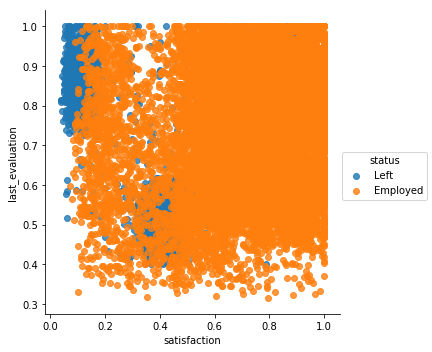

In [20]:
# Scatterplot of satisfaction vs. last_evaluation
sns.lmplot(x='satisfaction', y='last_evaluation', hue='status', data=df, fit_reg=False)

* This is a **bivariate segmentation** because we are plotting the relationship between two variables while segmenting classes using color.
* It's a quick way to see if there are potential interactions between different features.

Below is a scatterplot of 'satisfaction' and 'last_evaluation', but only for employees who have 'Left'.

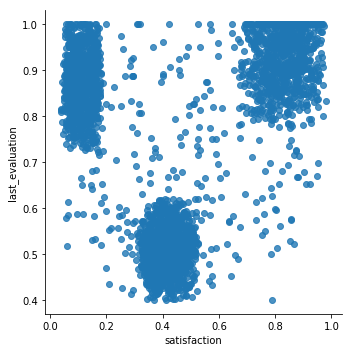

In [21]:
# Scatterplot of satisfaction vs. last_evaluation, only those who have left
sns.lmplot(x='satisfaction', y='last_evaluation', data=df[df.status == 'Left'], fit_reg=False)

We see 3 clusters and we can try to group them as follows:
* satisfaction < 0.2 (we can name them as 'Unhappy')
* last_evaluation < 0.6 (we can name them as 'Underperformers')
* satisfaction > 0.7 and last_evaluation > 0.8 (We can name them as 'Overachievers')

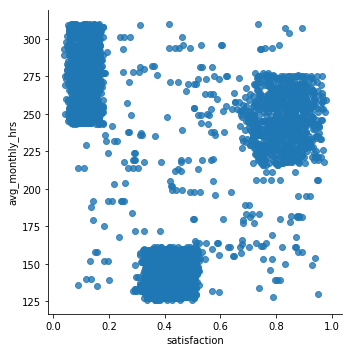

In [22]:
# Scatterplot of satisfaction vs. avg_monthly_hrs, only those who have left
sns.lmplot(x='satisfaction', y='avg_monthly_hrs', data=df[df.status == 'Left'], fit_reg=False)

We notice similar 3 clusters here as well.
* The left cluster (unhappy) -> putting a lot of effort and still not satisfied.
* The middle cluster (underperformer) -> not putting much effort.
* The right cluster (overachievers) -> putting more effort as well as satisfied

## 3.6 Correlations - Plot them as an exercise

# 4. Data Cleaning
## 4.1 De-duplication and dropping unwanted observations

In [23]:
print(df.shape)

(14249, 10)


In [24]:
# Drop duplicates
df = df.drop_duplicates()
print(df.shape)

(14221, 10)


28 observations were duplicates

** Drop the employees belonging to 'temp' department as discussed in EDA**

In [25]:
# Drop temporary workers
df = df[df.department != 'temp']
print(df.shape)

(14068, 10)


## 4.2 Fix structural errors

Remember the 'filed_complaint' and 'recently_promoted' features? They only had values of 1 and NaN.

In [26]:
# Print unique values of 'filed_complaint'
print( df.filed_complaint.unique() )

# Print unique values of 'recently_promoted'
print( df.recently_promoted.unique() )

[ nan   1.]
[ nan   1.]


Even though the NaN values are "missing," they actually indicate employees who have not filed complaints or those who have not been recently promoted.

* Therefore, we should fill them in with the value 0.
* This will turn them into true indicator variables.

In [27]:
# Missing filed_complaint values should be 0
df['filed_complaint'] = df.filed_complaint.fillna(0)

# Missing recently_promoted values should be 0
df['recently_promoted'] = df.recently_promoted.fillna(0)

In [28]:
## Sanity check

# Print unique values of 'filed_complaint'
print( df.filed_complaint.unique() )

# Print unique values of 'recently_promoted'
print( df.recently_promoted.unique() )

[ 0.  1.]
[ 0.  1.]


## 4.3 Typos and capitalization

Recall in EDA we saw 'IT' and 'information_technology' labeled as separate classes. Lets fix it.

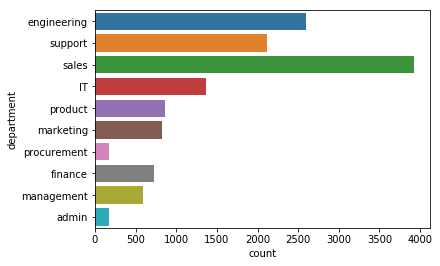

In [29]:
# 'information_technology' should be 'IT'
df.department.replace('information_technology', 'IT', inplace=True)

# Plot class distributions for 'department'
sns.countplot(y='department', data=df)

## 4.4 Outliers
An eye test for all the previous analysis tells us that it doesn't look like outliers will be a huge problem.

## 4.5 Missing Data

In [30]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

It looks like we have 1 categorical feature ('department') and 1 numeric feature ('last_evaluation') with missing data.

In [31]:
# Fill missing values in department with 'Missing'
# Equivalent to adding a new class
df['department'].fillna('Missing', inplace=True)

** Flag and fill missing numeric values**<br>
First, let's flag 'last_evaluation' with an indicator variable of missingness.

* 0 if not missing.
* 1 if missing.

Let's name the new indicator variable 'last_evaluation_missing'.

In [32]:
# Indicator variable for missing last_evaluation
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

Then, simply fill in the original missing value with 0 just so your algorithms can run properly.

In [33]:
# Fill missing values in last_evaluation with 0
df.last_evaluation.fillna(0, inplace=True)

Display the number of missing values for each feature (both categorical and numeric) again, just to confirm.

In [34]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

# 5. Feature Engineering
* Since our dataset is larger, we don't really suffer from sparse classes as much.
* We won't always have a lot of domain knowledge for the problem. In these situations, we should rely on exploratory analysis to provide us hints better feature engineering.

## 5.1 Indicator Variables
Create 3 indicator variables for 'underperformer', 'unhappy' and 'overacheivers' as discussed in the scatterplot of 'satisfaction' and 'last_evaluation' for employees who have 'Left'.

Let's reproduce it here again.

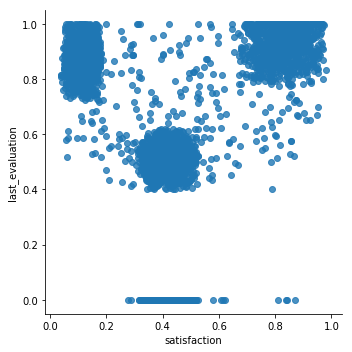

In [35]:
# Scatterplot of satisfaction vs. last_evaluation, only those who have left
sns.lmplot(x='satisfaction', y='last_evaluation', data=df[df.status == 'Left'], fit_reg=False)

That looks different from the one we plotted previously.

* It's because we just flagged and filled missing values for 'last_evaluation' with 0.
* No problem, let's ignore those observations for now and focus on the top half of the plot.

Based on the top half, it looks like there are 3 clusters of people who left.
1. First, we have people with high 'last_evaluation' but low 'satisfaction'. Maybe these people were overqualified, frustrated, or unhappy in some other way.
2. Next, we have people with low 'last_evaluation' and medium 'satisfaction'. These were probably underperformers or poor cultural fits.
3. Finally, we have people with high 'last_evaluation' and high 'satisfaction'. Perhaps these were overachievers who found better offers elsewhere.

These roughly translate to 3 indicator features we can engineer:
1. 'underperformer' - last_evaluation < 0.6 and last_evaluation_missing == 0
2. 'unhappy' - satisfaction_level < 0.2
3. 'overachiever' - last_evaluation > 0.8 and satisfaction > 0.7

**Important:**
* For 'underperformer', it's important to include the condition 'last_evaluation_missing' == 0 to avoid those originally missing observations that we flagged and filled.
* By including this extra condition we are actually excluding the missing obseravtions from being counted as underperformers.

In [36]:
# Create indicator features
df['underperformer'] = ((df.last_evaluation < 0.6) & 
                        (df.last_evaluation_missing == 0)).astype(int)

df['unhappy'] = (df.satisfaction < 0.2).astype(int)

df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

In [37]:
# The proportion of observations belonging to each group
df[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

** Finally convert 'status' (target variable) into a binary indicator variable.**
* 'Left' should be 1
* 'Employed' should be 0

In [38]:
# Convert status to an indicator variable
df['status'] = pd.get_dummies( df.status ).Left

To confirm we did that correctly, display the proportion of people in our dataset who left.

In [39]:
# The proportion of observations who 'Left'
df.status.mean()

0.23933750355416547

Matches with the earlier count. Seems good

## 5.2 One-Hot Encoding for categorical variables

In [40]:
# Create new dataframe with dummy features
df = pd.get_dummies(df, columns=['department', 'salary'])

# Display first 10 rows
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,underperformer,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,1,...,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Save this dataframe as your analytical base table to use for future use.**
* Remember to set the argument index=None to save only the data.

In [41]:
# Save analytical base table
df.to_csv('Files/analytical_base_table.csv', index=None)

# 6. Machine Learning Models
## 6.1 Data Preparation

In [42]:
print(df.shape)

(14068, 26)


### 6.1.1 Train test split

In [43]:
# Create separate object for target variable
y = df.status

# Create separate object for input features
X = df.drop('status', axis=1)

In [44]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df.status)



In [45]:
# Print number of observations in X_train, X_test, y_train, and y_test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11254, 25) (2814, 25) (11254,) (2814,)


### 6.1.2 Data standardization
* In Data Standardization we perform zero mean centring and unit scaling; i.e. we make the mean of all the features as zero and the standard deviation as 1.
* Thus we use **mean** and **standard deviation** of each feature.
* It is very important to save the **mean** and **standard deviation** for each of the feature from the **training set**, because we use the same mean and standard deviation in the test set.

In [46]:
train_mean = X_train.mean()
train_std = X_train.std()

In [47]:
## Save these mean and std dev values
train_mean.to_pickle("Save/train_mean.pkl")
train_std.to_pickle("Save/train_std.pkl")

In [48]:
## Standardize the train data set
X_train = (X_train - train_mean) / train_std

In [49]:
## Check for mean and std dev.
X_train.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
count,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,...,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04
mean,-1.410518e-16,-7.124507e-16,4.897691e-15,3.868467e-16,-1.181962e-15,-8.726773e-15,-2.701076e-16,3.084238e-16,-4.519616e-16,3.725965e-16,...,4.899375e-16,-1.424995e-15,-7.675820e-16,4.087597e-16,-4.383181e-16,1.926662e-16,1.515897e-15,-5.810174e-16,9.154851e-18,-6.200241e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.097551e+00,-4.066418e-01,-2.417939e+00,-1.455347e+00,-1.457128e-01,-2.327064e+00,-1.024920e+00,-3.267968e-01,-6.344341e-01,-3.151772e-01,...,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
25%,-9.142094e-01,-4.066418e-01,-4.586632e-01,-6.436473e-01,-1.457128e-01,-6.841787e-01,-3.396507e-01,-3.267968e-01,-6.344341e-01,-3.151772e-01,...,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
50%,-3.171743e-02,-4.066418e-01,1.388747e-01,1.680522e-01,-1.457128e-01,1.210881e-01,-3.396507e-01,-3.267968e-01,-6.344341e-01,-3.151772e-01,...,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
75%,8.908879e-01,-4.066418e-01,7.816106e-01,9.797517e-01,-1.457128e-01,8.126088e-01,3.456181e-01,-3.267968e-01,1.576068e+00,-3.151772e-01,...,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,1.606725e+00,-4.182927e-01,-2.983599e-01,1.023695e+00,1.151334e+00
max,2.194569e+00,2.458948e+00,1.311132e+00,2.603151e+00,6.862203e+00,1.518713e+00,4.457231e+00,3.059733e+00,1.576068e+00,3.172536e+00,...,4.224847e+00,4.627788e+00,4.052110e+00,9.007706e+00,3.930883e+00,1.606725e+00,2.390458e+00,3.351360e+00,1.023695e+00,1.151334e+00


In [50]:
## Note: We use train_mean and train_std_dev to standardize test data set
X_test = (X_test - train_mean) / train_std

In [51]:
## Check for mean and std dev. - not exactly 0 and 1
X_test.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,...,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,0.050369,0.029205,0.020064,0.032769,0.018652,0.007616,0.005419,-0.007881,-0.019358,0.031859,...,-0.028977,-0.055982,0.017524,0.008892,0.007391,-0.003675,0.026875,-0.010429,0.001426,0.004332
std,1.009275,1.029258,0.999263,1.016184,1.060773,1.017268,1.005757,0.989272,0.990786,1.044182,...,0.940117,0.866064,1.032797,1.038904,1.013605,0.998316,1.025946,0.984026,1.000166,1.000736
min,-2.077494,-0.406642,-2.417939,-1.455347,-0.145713,-2.326534,-1.024920,-0.326797,-0.634434,-0.315177,...,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
25%,-0.854040,-0.406642,-0.447861,-0.643647,-0.145713,-0.671221,-0.339651,-0.326797,-0.634434,-0.315177,...,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
50%,0.048509,-0.406642,0.195125,0.168052,-0.145713,0.149043,-0.339651,-0.326797,-0.634434,-0.315177,...,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
75%,0.925987,-0.406642,0.785055,0.979752,-0.145713,0.834208,0.345618,-0.326797,1.576068,-0.315177,...,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,1.606725,-0.418293,-0.298360,1.023695,1.151334
max,2.194569,2.458948,1.311132,2.603151,6.862203,1.518713,4.457231,3.059733,1.576068,3.172536,...,4.224847,4.627788,4.052110,9.007706,3.930883,1.606725,2.390458,3.351360,1.023695,1.151334


## 6.2 Model-1 Logistic Regression

In [85]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(), tuned_params, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [86]:
model.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
## Predict Train set results
y_train_pred = model.predict(X_train)

In [54]:
## Predict Test set results
y_pred = model.predict(X_test)

In [59]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [60]:
# Display first 10 predictions
y_pred_proba[:10]

array([ 0.03,  0.  ,  0.01,  0.09,  0.07,  0.48,  0.13,  0.62,  0.73,  0.14])

**Note:**
* The probality values represent the probability of a data point belonging to class 1 ('Left')
* For example:

In [61]:
i=213  ## Change the value of i to get the details of any point (56, 213, etc.)
print('For test point {}, actual class = {}, precited class = {}, predicted probability = {}'.
      format(i, y_test.iloc[i], y_pred[i], y_pred_proba[i]))

For test point 213, actual class = 1, precited class = 0, predicted probability = 0.3414931406016799


* These probabilistic outputs are very important for understanding how confident the model is about the prediction.
* Probabilities near 0 or 1 means the model is very confident and those near 0.5 means the model is not very confident about the prediction.

In [62]:
confusion_matrix(y_test, y_pred).T

array([[1969,  220],
       [ 172,  453]], dtype=int64)

In [63]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

**Note:** Refere at the end for a detailed explanation on ROC-AUC

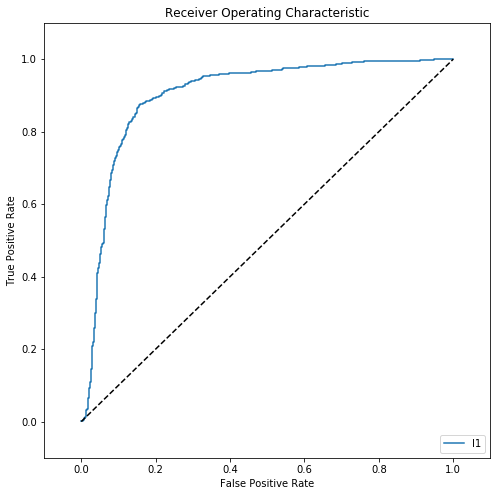

In [265]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
# Calculate AUC for Train set
print(roc_auc_score(y_train, y_train_pred))

0.777522306406


In [64]:
# Calculate AUC for Test set
print(auc(fpr, tpr))

0.901536755332


#### Feature Importance

In [52]:
## Building the model again with the best hyperparameters
model = LogisticRegression(C=10, penalty = 'l2')
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [267]:
indices = np.argsort(-abs(model.coef_[0,:]))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
satisfaction
overachiever
last_evaluation_missing
underperformer
last_evaluation
filed_complaint
n_projects
salary_high
tenure
avg_monthly_hrs
salary_low
recently_promoted
unhappy
department_procurement
department_management
department_Missing
department_engineering
department_admin
department_product
department_marketing
department_finance
department_IT
salary_medium
department_support
department_sales


## 6.3 Model-2 Random Forest

In [118]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [119]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
y_train_pred = model.predict(X_train)

In [68]:
y_pred = model.predict(X_test)

In [69]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [70]:
# Display first 10 predictions
y_pred_proba[:10]

array([ 0.02,  0.  ,  0.07,  0.  ,  0.13,  0.04,  0.73,  0.97,  0.98,  0.01])

**Note:** Just as above, we can use these probabilities for model interpretation

In [71]:
confusion_matrix(y_test, y_pred).T

array([[2129,   60],
       [  12,  613]], dtype=int64)

In [72]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

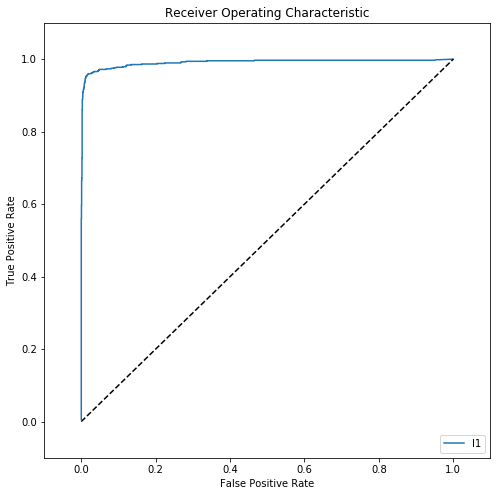

In [274]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
# Calculate AUC for Train set
roc_auc_score(y_train, y_train_pred)

0.97311284509016216

In [74]:
# Calculate AUC for Test set
print(auc(fpr, tpr))

0.991401165805


#### Feature Importance

In [65]:
## Building the model again with the best hyperparameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [276]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
satisfaction
n_projects
tenure
avg_monthly_hrs
last_evaluation
unhappy
overachiever
underperformer
filed_complaint
salary_low
salary_high
last_evaluation_missing
department_engineering
department_sales
salary_medium
department_support
recently_promoted
department_IT
department_finance
department_management
department_Missing
department_marketing
department_product
department_procurement
department_admin


## 6.4 Model-3 XGBoost

In [132]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=15, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [1, 2, 3, 4, 5], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [133]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
y_train_pred = model.predict(X_train)

In [77]:
y_pred = model.predict(X_test)

In [78]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [79]:
# Display first 10 predictions
y_pred_proba[:10]

array([ 0.02,  0.01,  0.04,  0.01,  0.08,  0.01,  0.94,  0.96,  0.99,  0.  ], dtype=float32)

**Note:** Just as above we can use these probabilities to get model interpretation

In [80]:
confusion_matrix(y_test, y_pred).T

array([[2119,   53],
       [  22,  620]], dtype=int64)

In [81]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

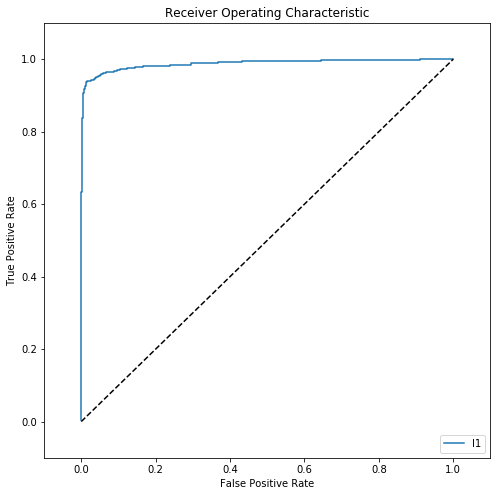

In [283]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [82]:
# Calculate AUC for Train
roc_auc_score(y_train, y_train_pred)

0.96222854179242212

In [83]:
# Calculate AUC for Test
print(auc(fpr, tpr))

0.987454307849


#### Feature Importance

In [75]:
model = XGBClassifier(max_depth=5,learning_rate=0.05,n_estimators=300, reg_lambda=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [285]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

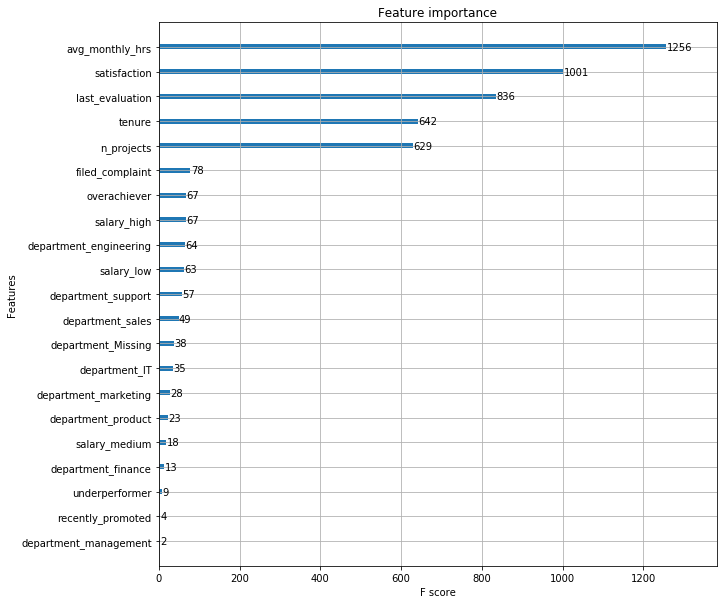

In [286]:
my_plot_importance(model, (10,10))

# 7. Save the winning model to disk

In [287]:
win_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'Save/rfc_emp_retention.pkl') 

['rfc_emp_retention.pkl']

# 8. Assignments
* Try some more data analysis and feature engineering
* Apply other methods like KNN, SVM, Decision Trees
* Perform hyperparameter tuning for these models

### A note on ROC-AUC

For classification problems, the default scoring metric is accuracy.
* Accuracy is simply the percent of observations correctly classified by the model.
* However, straight accuracy is not always the best way to evaluate a classification model.
* Specifically, it's not a good metric when evaluating imbalanced classes in your target variable. (we have discussed in detail).
* Area under ROC curve is the most reliable metric for classification tasks. At least for binary classification problems.
* However, there is an even better metric called 'log-loss' which is useful even in multi-class classification also and we will get to that in a later case study.

***Area under ROC curve*** is equivalent to the probability that a randomly chosen *'Left'* observation ranks higher (has a higher predicted probability) than a randomly chosen *'Employed'* observation.

Basically, it's saying... if you grabbed two observations and exactly one of them was the positive class and one of them was the negative class, what's the likelihood that your model can distinguish the two?

### Let's first discuss what a confusion matrix is:

For binary classification, there are 4 possible outcomes for any given prediction.

1. True positive - Predict 1 when the actual class is 1.
2. False positive - Predict 1 when the actual class is 0.
3. True negative - Predict 0 when the actual class is 0.
4. False negative - Predict 0 when the actual class is 1

In [288]:
## Building the model for Logistic Regression again with the best hyperparameters
model = LogisticRegression(C=10, penalty = 'l2')
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [289]:
y_pred = model.predict(X_test)

In [290]:
confusion_matrix(y_test, y_pred)

array([[1969,  172],
       [ 220,  453]], dtype=int64)

Here's how to interpret that output:

* The first column includes observations that were predicted to be 1.
* The second column includes observations that were predicted to be 0.
* The first row includes observations that were actually 1.
* The second row includes observations that were actually 0.

Therefore, among the 2814 observations in the test set, 2422 (diagonal elements) were correctly classified.
* 1969 were true positives (first column, first row)
* 453 were true negatives (second column, second row)

On the other hand, 392 (non-diagonal elements) were incorrectly classified.
* 220 were false positives (first column, second row)
* 172 were false negatives (second column, first row)

As you can see, if you combine this information, it goes far beyond simple accuracy. Namely, you separately evaluate the performance for each class. This means the dominant class will not dominate your performance metric.

### TPR and FPR

The confusion matrix allows you to calculate two important metrics that are both combinations of elements in the matrix.
* **True positive rate (TPR)**, also known as recall, is defined as TP/(TP+FN). In other words, it's the proportion of all positive observations that are correctly predicted to be positive.
* **False positive rate (FPR)** is defined as FP/(FP+TN). In other words, it's the proportion of all negative observations that are incorrectly predicted to be positive.

Obviously, we want TPR to be higher and FPR to be lower... However, they are intertwined in an important way.

#### Probability thresholds
Remember, we can predict a probability for each class using .predict_proba(), instead of the class directly. For example

In [291]:
y_pred_proba = model.predict_proba(X_test)[:,1]

In [292]:
print(y_pred_proba[:10])
print(y_pred[:10])

[ 0.03  0.    0.01  0.09  0.07  0.48  0.13  0.62  0.73  0.14]
[0 0 0 0 0 0 0 1 1 0]


**Note:**
* The points whose predicted probality is greater than 0.5 are labelled as class 1 and whose predicted probality is less than 0.5 are labelled as class 0.
* In other words, 0.5 was the **threshold**.

However, you can theoretically alter that threshold, depending on your goals.
* Lowering it will make positive class predictions more likely.
* Raising it will make negative class predictions more likely.
* The threshold you choose is independent of the model.

Here's where TPR and FPR are intertwined!
* If you lower the threshold, the true positive rate increases, but so does the false positive rate.
* Remember, TPR is the proportion of all actually positive observations that were predicted to be positive.
* That means a model that always predicts the positive class will have a true positive rate of 100%.
* However, FPR is the proportion of all actually negative observations that were predicted to be positive.
* Therefore, a model that always predicts the positive class will also have a false positive rate of 100%!

And that finally brings us to the ROC curve!

### ROC curve
The ROC curve is a way to visualize the relationship between TPR and FPR for classification models.
* It simply plots the true positive rate and false positive rate at different thresholds.

To illustrate this, let's calculate the ROC curve using the roc_curve() function that we imported earlier.

In [293]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

This function returns 3 lists of equal length:
1. False positive rates
2. True positive rates
3. And the thresholds at which the those were calculated.

We can throw these into a DataFrame for convenience and look at the last 10:

In [294]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds}).tail(10)

,FPR,TPR,Thresholds
534,0.759925,0.994056,0.009661
535,0.784680,0.994056,0.008159
536,0.784680,0.995542,0.008095
537,0.910322,0.995542,0.001974
538,0.910322,0.997028,0.001959
539,0.932742,0.997028,0.001402
540,0.932742,0.998514,0.001396
541,0.949089,0.998514,0.001056
542,0.949089,1.000000,0.001046
543,1.000000,1.000000,0.000027


As you can see, as you decrease the threshold, both the false positive rate and the true positive rate increase.

We can plot the entire curve like so:

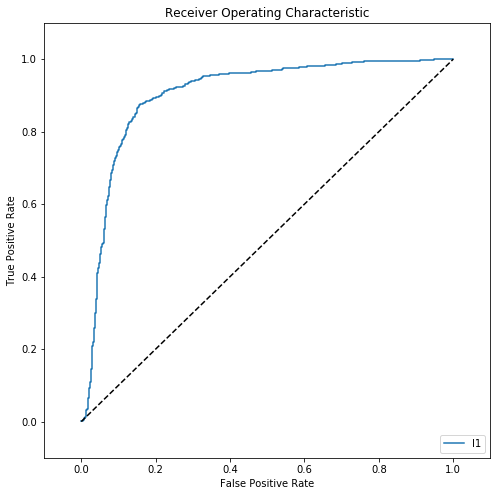

In [295]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The 45 degree **dotted black line** represents the ROC curve of a hypothetical model that makes **completely random predictions**.

Basically, we want our model's curve, the blue line, to sit as far above that dotted black line as possible.

### AUC
And finally that brings us to AUC, or area under ROC curve.

This is literally the area under that **blue line**.
* The AUC for a completely random model will be 0.5.
* The maximum AUC possible is 1.0.

Remember, that AUC is equivalent to the probability that a randomly chosen 'Left' observation ranks higher (has a higher predicted probability) than a randomly chosen 'Employed' observation.

To calculate this, we can use the auc() function we imported earlier in conjunction with the roc_curve() function.

In [296]:
# Calculate AUROC
print(auc(fpr, tpr))

0.901536755332


So our logistic regression has a 90.15% chance of distinguishing between a positive observation and a negative one... not bad!

**Important Points:**
* ROC Curves are useful even if the predicted probabilities are **not** "properly calibrated".
* AUC is a useful metric even when your classes are highly unbalanced.
* Choosing a classification **threshold** is a busiess decision. Minimize FPR or maximize TPR.